## Deep Kernel Pairwise GP for Preference-Based Bayesian Optimization


### Imports

In [1]:
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

### Import DeepKernelPairwiseGP modules

In [ ]:
import sys
# Add the directory of the modules
sys.path.insert(0, r'/Users/yla/ORNL Dropbox/Yongtao Liu/MyFiles/CNMS_2025/Githublocal/DeepKernelPairwiseGP')
from model import fit_dkpg, predict_utility
from acq import acq_eubo, get_user_preference, sample_comparison_pairs
from utils import get_grid_coords, get_subimages, plot_option, plot_predictions, acquire_preference

### Load Data

In [3]:
def loop_area(raw_spec, cycle):
    """Calculate loop area from spectrum."""
    raw_spec_len = len(raw_spec)
    cycle_len = int(raw_spec_len / cycle)
    half_len = int(cycle_len / 2)
    q_len = int(cycle_len / 4)
    loop_top, loop_bottom = [], []
    loop_top.append(raw_spec[q_len : q_len + half_len])
    loop_top.append(raw_spec[q_len + 2*half_len : q_len + 3*half_len])
    loop_top.append(raw_spec[q_len + 4*half_len : 2*q_len + 4*half_len])
    loop_bottom.append(raw_spec[:q_len])
    loop_bottom.append(raw_spec[q_len + half_len: q_len + 2*half_len])
    loop_bottom.append(raw_spec[q_len + 3*half_len: q_len + 4*half_len])
    loop_top = np.concatenate(loop_top)
    loop_bottom = np.concatenate(loop_bottom)
    return np.abs(np.sum(loop_top) - np.sum(loop_bottom))

norm_ = lambda x: (x - x.min()) / np.ptp(x)

In [4]:
bepsdata = np.load('BEPS_PTO_1d7um.npz')
amp_off_field = bepsdata['amp_off_field']
pha_off_field = bepsdata['pha_off_field']
v_step = bepsdata['v_step']

In [5]:
pola_off_field = amp_off_field * np.cos(pha_off_field)*1e3

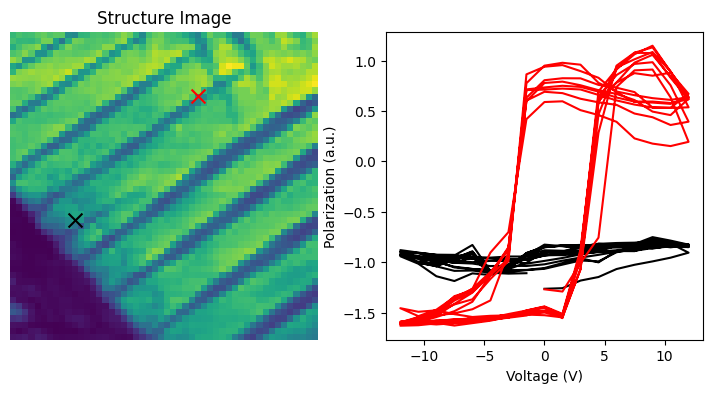

In [6]:
# Cut region for exploration
exp_data = pola_off_field[50:, 40:90]
img_data = amp_off_field[50:, 40:90]
struc_img = img_data.mean(2)

# Visualize
plot_pixx1, plot_pixy1 = 10, 30
plot_pixx2, plot_pixy2 = 30, 10

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(struc_img)
ax1.scatter(plot_pixx1, plot_pixy1, marker='x', s=100, c='k')
ax1.scatter(plot_pixx2, plot_pixy2, marker='x', s=100, c='r')
ax1.set_title('Structure Image')
ax1.axis("off")

ax2.plot(v_step, exp_data[plot_pixx1, plot_pixy1], c='k')
ax2.plot(v_step, exp_data[plot_pixx2, plot_pixy2], c='r')
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('Polarization (a.u.)')


plt.show()

## Prepare Training Data

In [7]:
# Extract image patches and spectra
img = norm_(struc_img)
spectra = norm_(exp_data)

coordinates = get_grid_coords(img, step=1)
window_size = 16
features_all, coords, _ = get_subimages(img, coordinates, window_size)
features_all = features_all[:,:,:,0]
coords = np.array(coords, dtype=int)
targets = spectra[coords[:, 0], coords[:, 1]]

print('Coordinates shape:', coords.shape)
print('Image patches shape:', features_all.shape)
print('Spectra shape:', spectra.shape)
print('Target spectra shape:', targets.shape)

Coordinates shape: (1225, 2)
Image patches shape: (1225, 16, 16)
Spectra shape: (50, 50, 256)
Target spectra shape: (1225, 256)


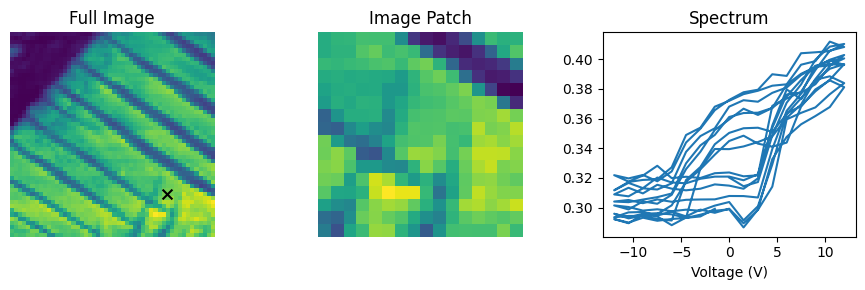

In [8]:
# Visualize example patch
k_example = 100
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), dpi=100)
ax1.imshow(img, origin='lower')
ax1.scatter(coords[k_example, 1], coords[k_example, 0], marker='x', s=50, c='k')
ax1.axis("off")
ax1.set_title('Full Image')

ax2.imshow(features_all[k_example], origin='lower')
ax2.axis("off")
ax2.set_title('Image Patch')

ax3.plot(v_step, spectra[coords[k_example, 0], coords[k_example, 1]])
ax3.set_title('Spectrum')
ax3.set_xlabel('Voltage (V)')
plt.tight_layout()
plt.show()

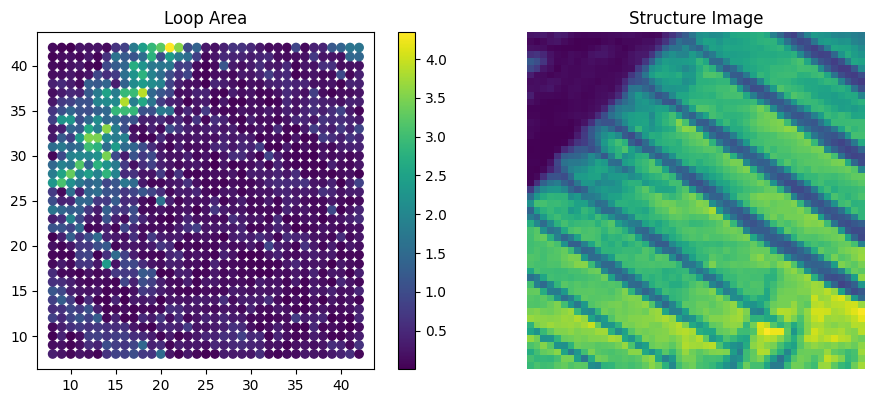

In [9]:
# Normalize and compute loop areas
features = norm_(features_all)
targets = norm_(targets)

loop_areas_all = []
for i, t in enumerate(targets):
    looparea = loop_area(t, 3)
    loop_areas_all.append(np.array([looparea]))

loop_areas_all = np.concatenate(loop_areas_all)

# Visualize loop areas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
a = ax1.scatter(coords[:, 1], coords[:, 0], c=loop_areas_all, cmap='viridis')
plt.colorbar(a, ax=ax1)
ax1.set_title('Loop Area')
ax1.set_aspect('equal')

ax2.imshow(struc_img, origin="lower")
ax2.set_title('Structure Image')
ax2.axis("off")
plt.tight_layout()
plt.show()

In [10]:
# Prepare data arrays
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)  # Flattened patches for DKL
y = norm_(loop_areas_all)  # Scalarized values

print(f"X_train shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Coords shape: {coords.shape}")

X_train shape: (1225, 256)
y shape: (1225,)
Coords shape: (1225, 2)


### Active Learning Loop

In [11]:
# Select initial training points
np.random.seed(42)
start_size = 5
train_indices = np.random.choice(np.arange(1, n), size=start_size, replace=False)
print("Initial training indices (pool indices):", train_indices)

X_train = X[train_indices]
y_train = y[train_indices]
coord_train = coords[train_indices]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Coordinates shape: {coord_train.shape}")

Initial training indices (pool indices): [662 221 156 678 912]
X_train shape: (5, 256)
y_train shape: (5,)
Coordinates shape: (5, 2)


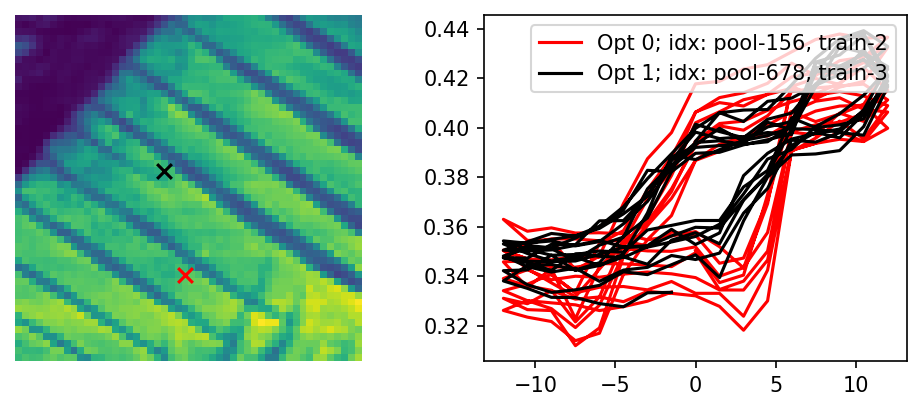

Recorded: train_idx 2 > train_idx 3


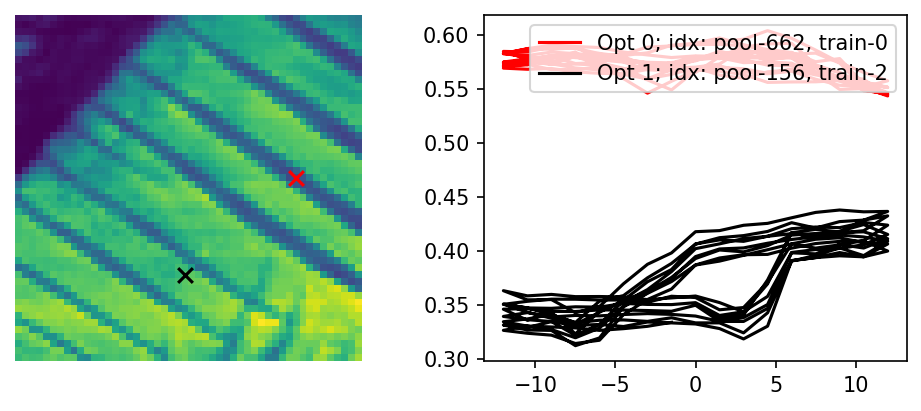

Recorded: train_idx 2 > train_idx 0


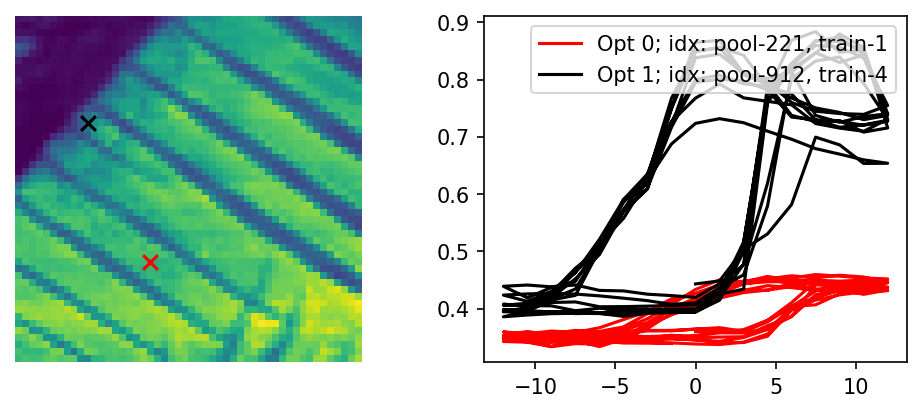

Recorded: train_idx 4 > train_idx 1


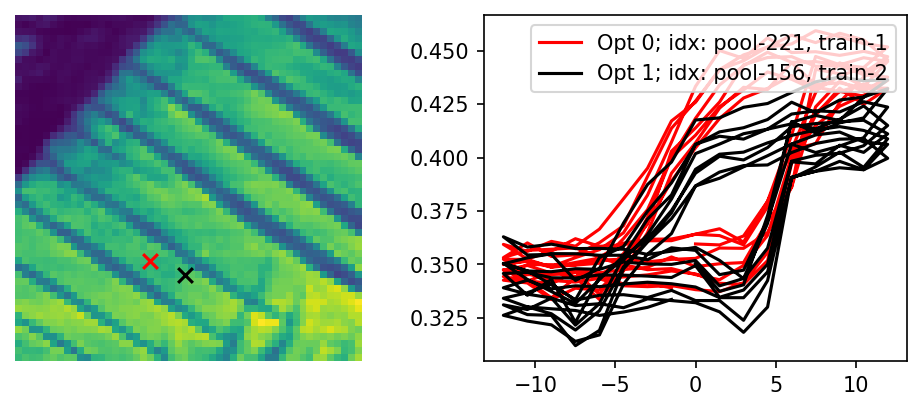

Recorded: train_idx 1 > train_idx 2


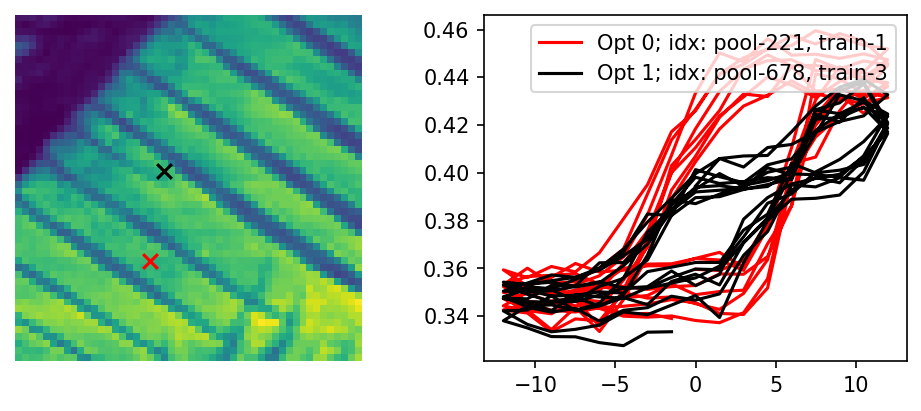

Recorded: train_idx 1 > train_idx 3
Initial comparisons shape: torch.Size([5, 2])
Total initial comparisons: 5


In [ ]:
# Run initial comparison session
start_pair_size = start_size  # Number of initial comparison pairs
np.random.seed(1)

# Generate random pairs for initial comparison
random.seed(2)
explicit_start_pairs = list(itertools.combinations(range(len(train_indices)), 2))
selected_pairs = random.sample(explicit_start_pairs, min(start_pair_size, len(explicit_start_pairs)))

preference_log = []

for idx, (i, j) in enumerate(selected_pairs):
    pool_idx_i = train_indices[i]
    pool_idx_j = train_indices[j]

    # Plot both options
    plot_option(img, coords,  spectra, v_step, pool_idx=[pool_idx_i,pool_idx_j],train_idx=[i,j])

    # Get preference
    preferred_idx, dispreferred_idx = get_user_preference(i, j, pair_num=idx + 1, 
                                                          total_pairs=len(selected_pairs))

    preference_log.append([preferred_idx, dispreferred_idx])
    print(f"Recorded: train_idx {preferred_idx} > train_idx {dispreferred_idx}")

# Convert to tensor
train_comp = torch.tensor(preference_log, dtype=torch.long)
print(f"Initial comparisons shape: {train_comp.shape}")
print(f"Total initial comparisons: {len(train_comp)}")

Exploration Step 1/5
Training Deep Kernel PairwiseGP Model
Training on cpu
Input dim: 256, Feature dim: 2
Comparisons: 5
Epoch 100/1000, Loss: 3.4839
Epoch 200/1000, Loss: 3.4733
Epoch 300/1000, Loss: 3.4699
Epoch 400/1000, Loss: 3.4684
Epoch 500/1000, Loss: 3.4675
Epoch 600/1000, Loss: 3.4671
Epoch 700/1000, Loss: 3.4667
Epoch 800/1000, Loss: 3.4665
Epoch 900/1000, Loss: 3.4664
Epoch 1000/1000, Loss: 3.4662


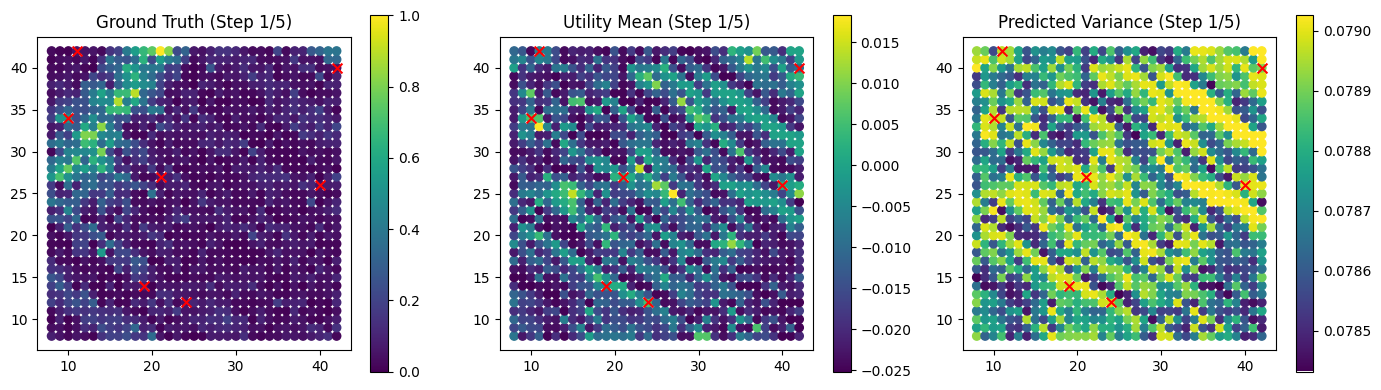

Evaluated 4950 pairs
Skipped 0 duplicate points
Skipped 0 previously compared pairs
Selected: indices (872, 1216)
Next comparison pair (pool indices): (872, 1216)
Point 1: pool_idx=872, coords=[32 40]
Point 2: pool_idx=1216, coords=[42 34]
Added 2 new points to training set
New pool indices: [872, 1216]
Comparison 1/3


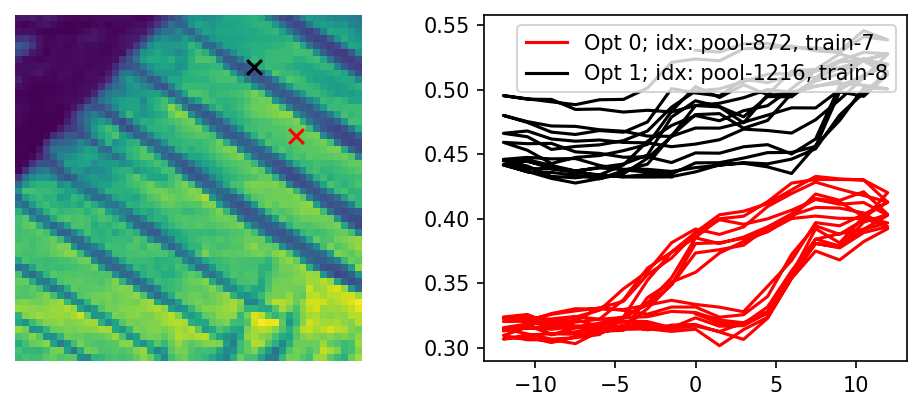

Recorded: train_idx 7 > train_idx 8
Comparison 2/3


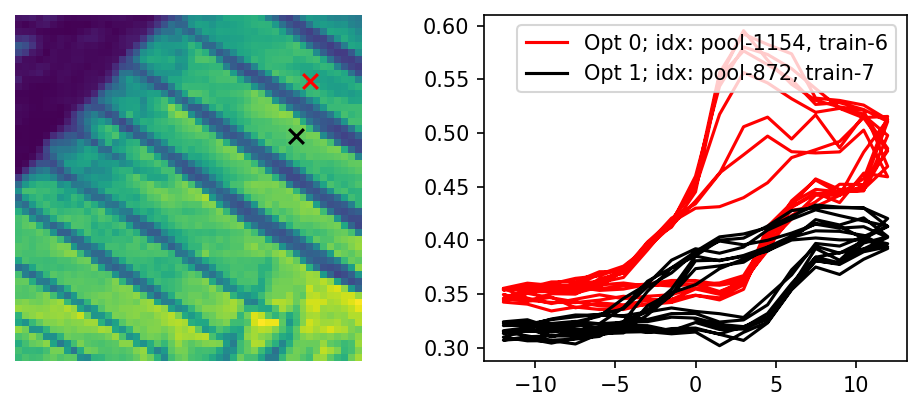

Recorded: train_idx 6 > train_idx 7
Comparison 3/3


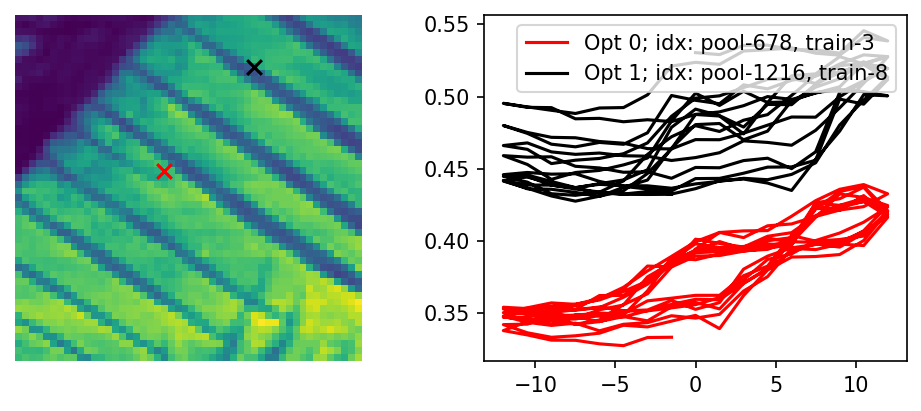

Recorded: train_idx 3 > train_idx 8
Step 1 Summary
Total training points: 9
Total comparisons: 6
Unique acquisition pairs tracked: 6
Current best training index: 4 (pool_idx=912)
Exploration Step 2/5
Training Deep Kernel PairwiseGP Model
Training on cpu
Input dim: 256, Feature dim: 2
Comparisons: 6
Epoch 100/1000, Loss: 4.0166
Epoch 200/1000, Loss: 3.8949
Epoch 300/1000, Loss: 3.8095
Epoch 400/1000, Loss: 3.7488
Epoch 500/1000, Loss: 3.7029
Epoch 600/1000, Loss: 3.6663
Epoch 700/1000, Loss: 3.6361
Epoch 800/1000, Loss: 3.6103
Epoch 900/1000, Loss: 3.5878
Epoch 1000/1000, Loss: 3.5680


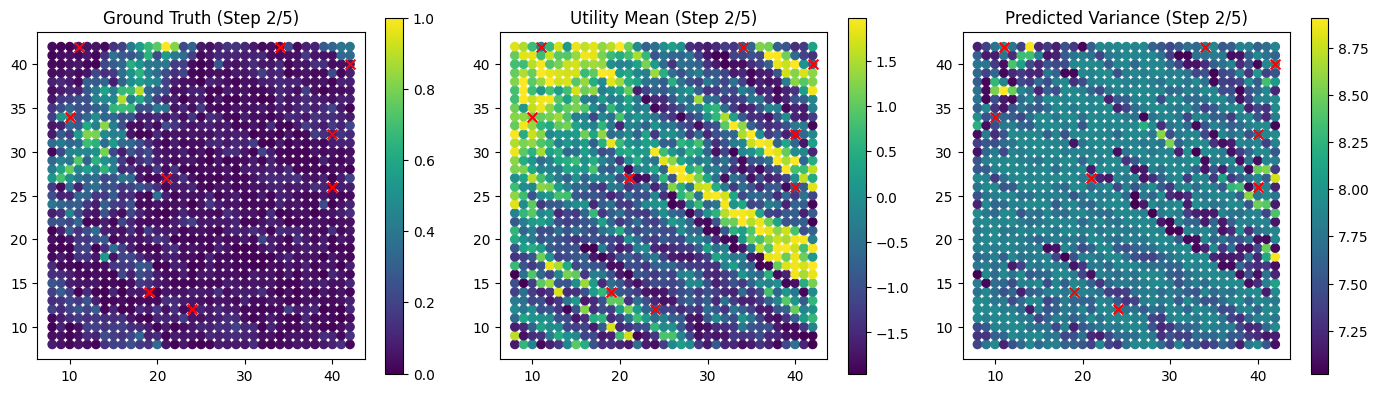

Evaluated 4950 pairs
Skipped 0 duplicate points
Skipped 0 previously compared pairs
Selected: indices (585, 485)
Next comparison pair (pool indices): (585, 485)
Point 1: pool_idx=585, coords=[24 33]
Point 2: pool_idx=485, coords=[21 38]
Added 2 new points to training set
New pool indices: [585, 485]
Comparison 1/3


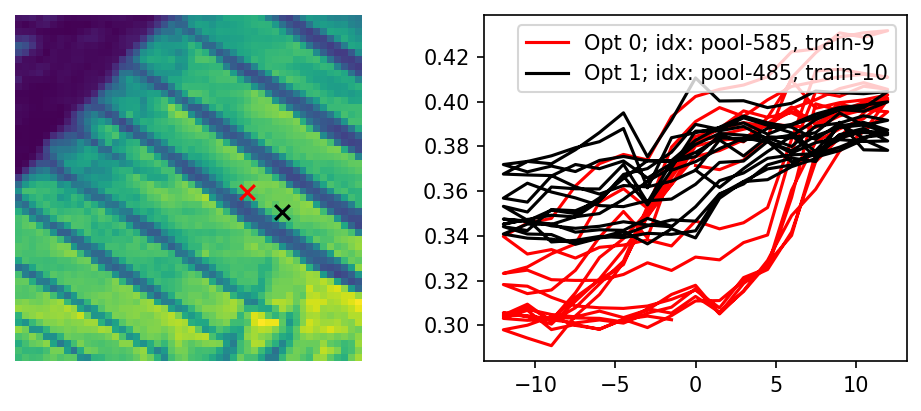

Recorded: train_idx 9 > train_idx 10
Comparison 2/3


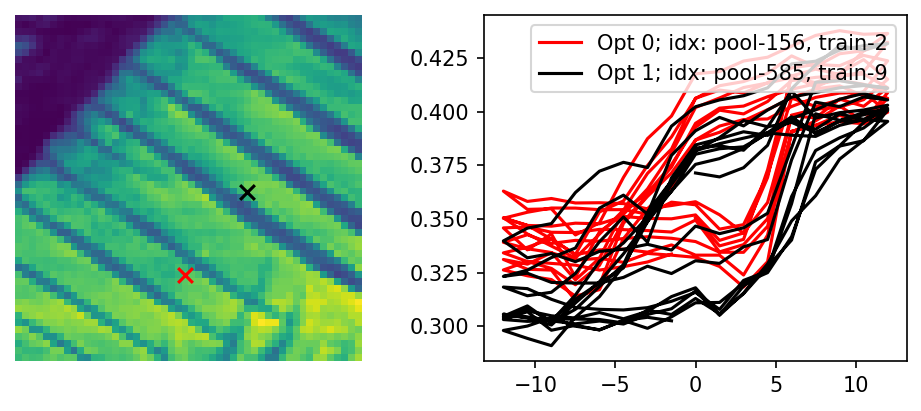

Recorded: train_idx 9 > train_idx 2
Comparison 3/3


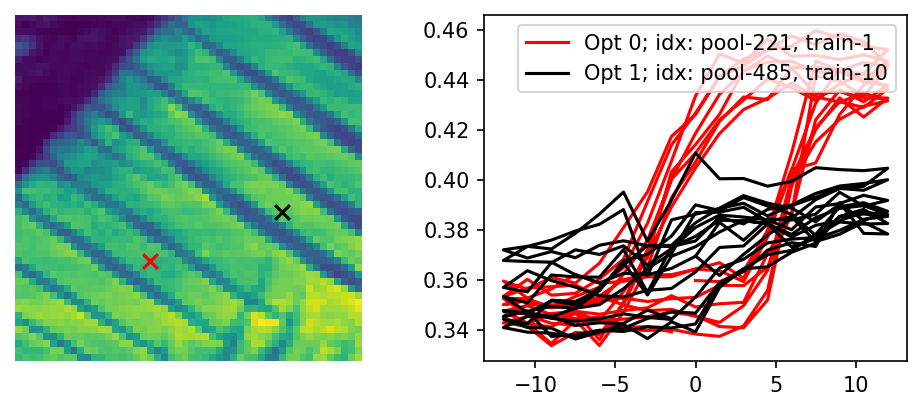

Recorded: train_idx 10 > train_idx 1
Step 2 Summary
Total training points: 11
Total comparisons: 7
Unique acquisition pairs tracked: 7
Current best training index: 4 (pool_idx=912)
Exploration Step 3/5
Training Deep Kernel PairwiseGP Model
Training on cpu
Input dim: 256, Feature dim: 2
Comparisons: 7
Epoch 100/1000, Loss: 4.9498
Epoch 200/1000, Loss: 4.8952
Epoch 300/1000, Loss: 4.8774
Epoch 400/1000, Loss: 4.8691
Epoch 500/1000, Loss: 4.8644
Epoch 600/1000, Loss: 4.8615
Epoch 700/1000, Loss: 4.8596
Epoch 800/1000, Loss: 4.8582
Epoch 900/1000, Loss: 4.8572
Epoch 1000/1000, Loss: 4.8564


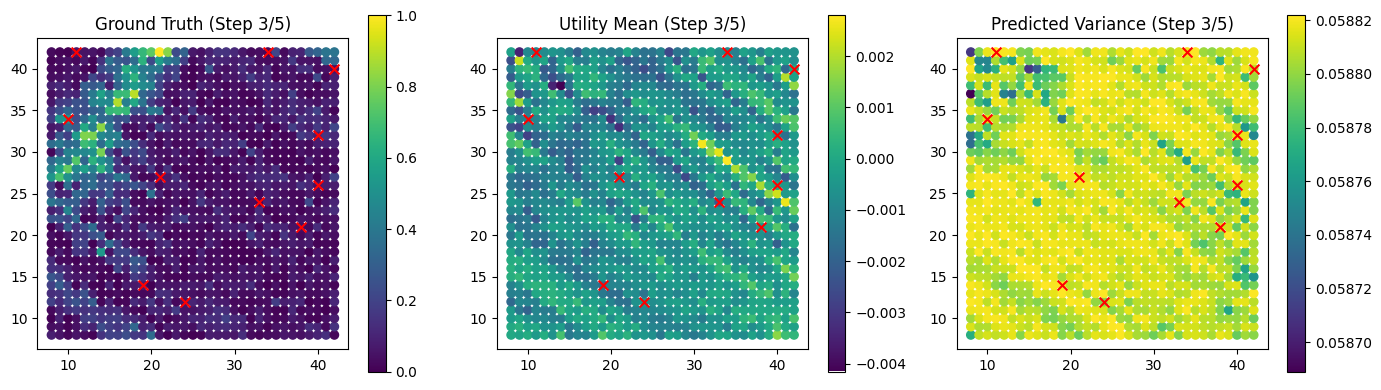

Evaluated 4949 pairs
Skipped 0 duplicate points
Skipped 1 previously compared pairs
Selected: indices (1153, 1066)
Next comparison pair (pool indices): (1153, 1066)
Point 1: pool_idx=1153, coords=[40 41]
Point 2: pool_idx=1066, coords=[38 24]
Added 2 new points to training set
New pool indices: [1153, 1066]
Comparison 1/3


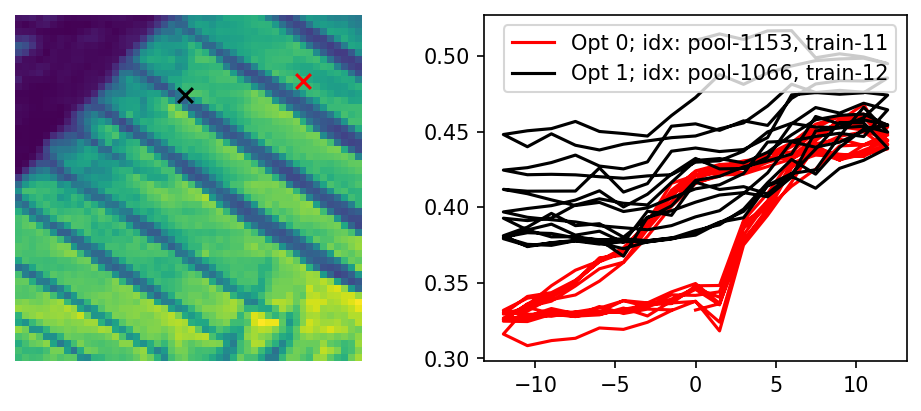

Recorded: train_idx 11 > train_idx 12
Comparison 2/3


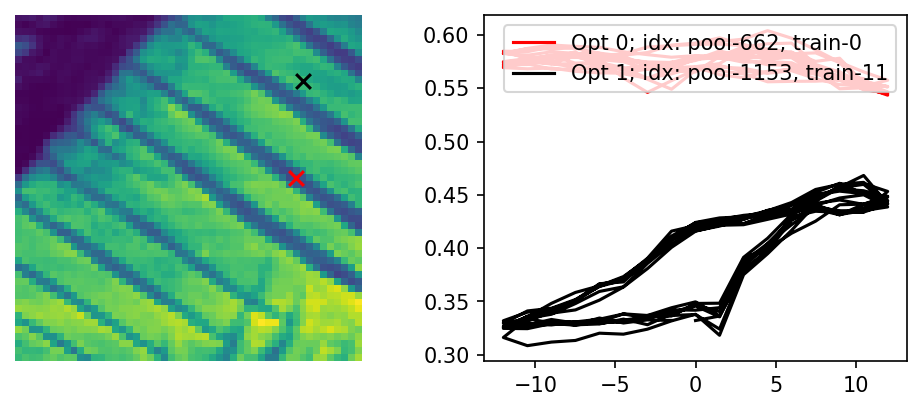

Recorded: train_idx 11 > train_idx 0
Comparison 3/3


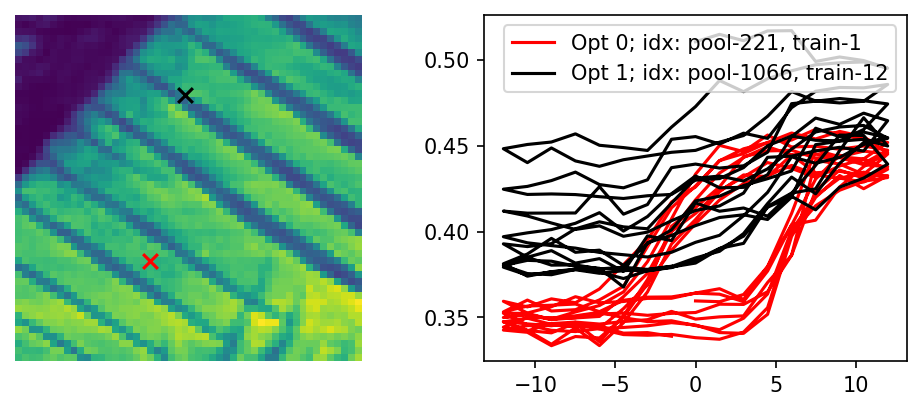

Recorded: train_idx 1 > train_idx 12
Step 3 Summary
Total training points: 13
Total comparisons: 8
Unique acquisition pairs tracked: 8
Current best training index: 6 (pool_idx=1154)
Exploration Step 4/5
Training Deep Kernel PairwiseGP Model
Training on cpu
Input dim: 256, Feature dim: 2
Comparisons: 8
Epoch 100/1000, Loss: 5.5189
Epoch 200/1000, Loss: 5.5007
Epoch 300/1000, Loss: 5.4855
Epoch 400/1000, Loss: 5.4747
Epoch 500/1000, Loss: 5.4672
Epoch 600/1000, Loss: 5.4618
Epoch 700/1000, Loss: 5.4577
Epoch 800/1000, Loss: 5.4545
Epoch 900/1000, Loss: 5.4519
Epoch 1000/1000, Loss: 5.4498


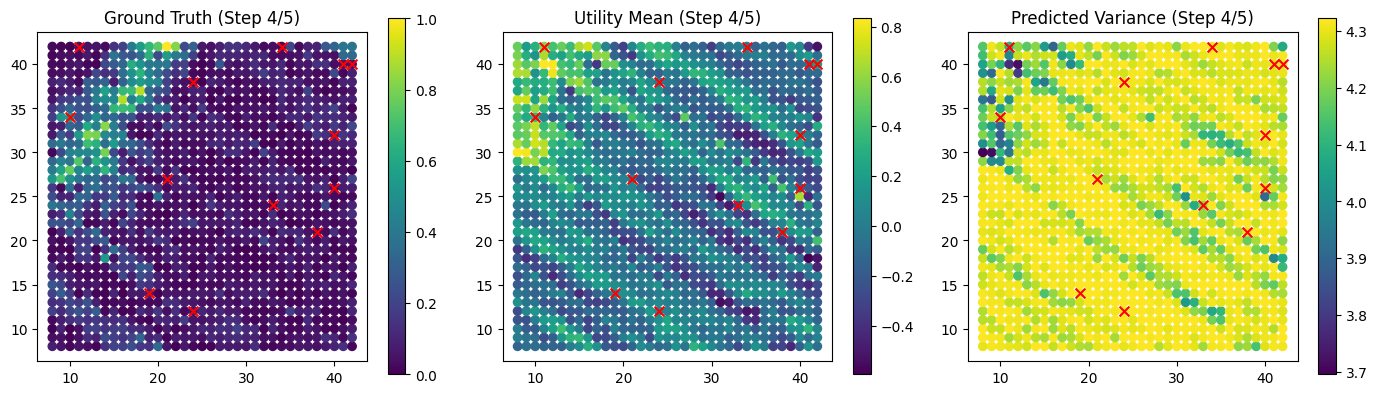

Evaluated 4947 pairs
Skipped 0 duplicate points
Skipped 3 previously compared pairs
Selected: indices (47, 156)
Next comparison pair (pool indices): (47, 156)
Point 1: pool_idx=47, coords=[ 9 20]
Point 2: pool_idx=156, coords=[12 24]
Added 1 new points to training set
New pool indices: [47]
Comparison 1/2


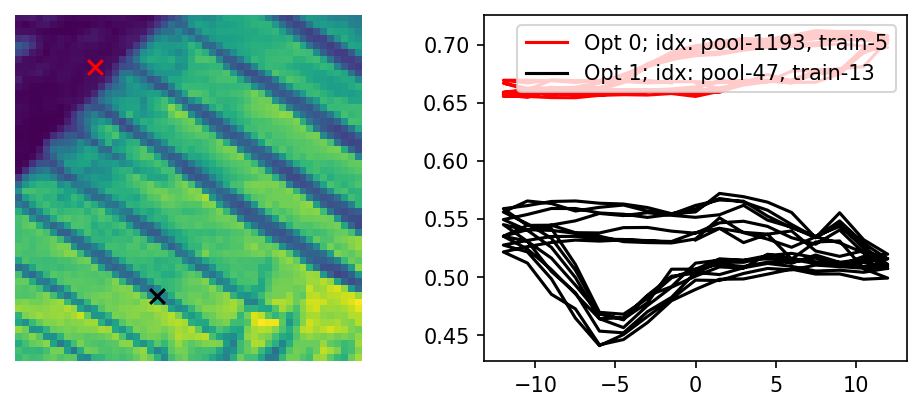

Recorded: train_idx 13 > train_idx 5
Comparison 2/2


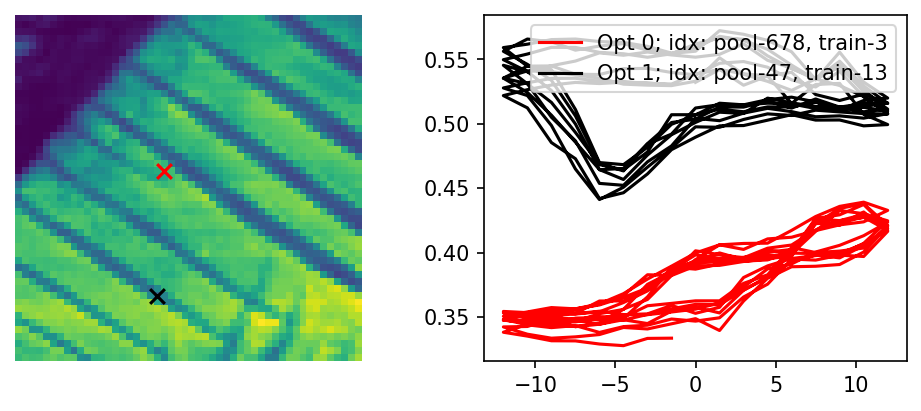

Recorded: train_idx 13 > train_idx 3
Step 4 Summary
Total training points: 14
Total comparisons: 9
Unique acquisition pairs tracked: 9
Current best training index: 5 (pool_idx=1193)
Exploration Step 5/5
Training Deep Kernel PairwiseGP Model
Training on cpu
Input dim: 256, Feature dim: 2
Comparisons: 9
Epoch 100/1000, Loss: 6.3065
Epoch 200/1000, Loss: 6.2691
Epoch 300/1000, Loss: 6.2567
Epoch 400/1000, Loss: 6.2509
Epoch 500/1000, Loss: 6.2476
Epoch 600/1000, Loss: 6.2455
Epoch 700/1000, Loss: 6.2441
Epoch 800/1000, Loss: 6.2431
Epoch 900/1000, Loss: 6.2423
Epoch 1000/1000, Loss: 6.2417


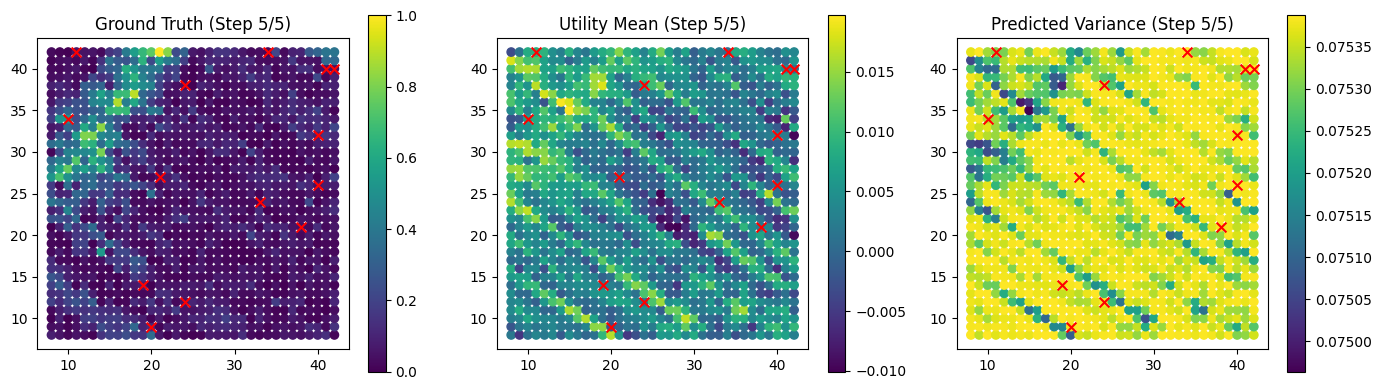

Evaluated 4948 pairs
Skipped 0 duplicate points
Skipped 2 previously compared pairs
Selected: indices (1075, 1188)
Next comparison pair (pool indices): (1075, 1188)
Point 1: pool_idx=1075, coords=[38 33]
Point 2: pool_idx=1188, coords=[41 41]
Added 2 new points to training set
New pool indices: [1075, 1188]
Comparison 1/3


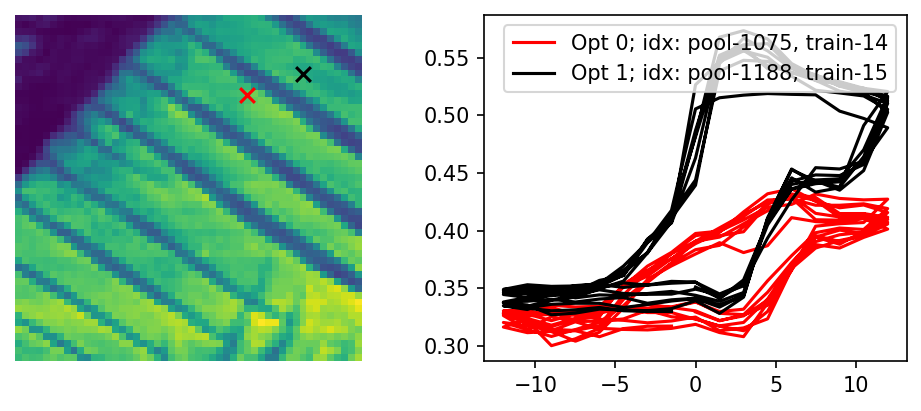

Recorded: train_idx 15 > train_idx 14
Comparison 2/3


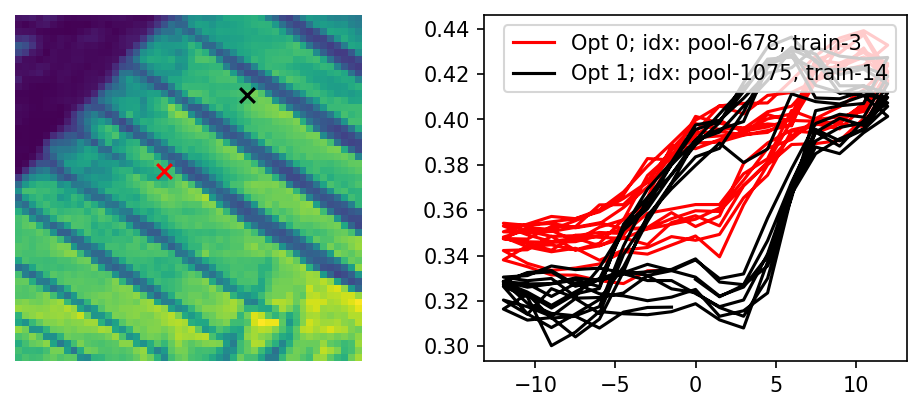

Recorded: train_idx 14 > train_idx 3
Comparison 3/3


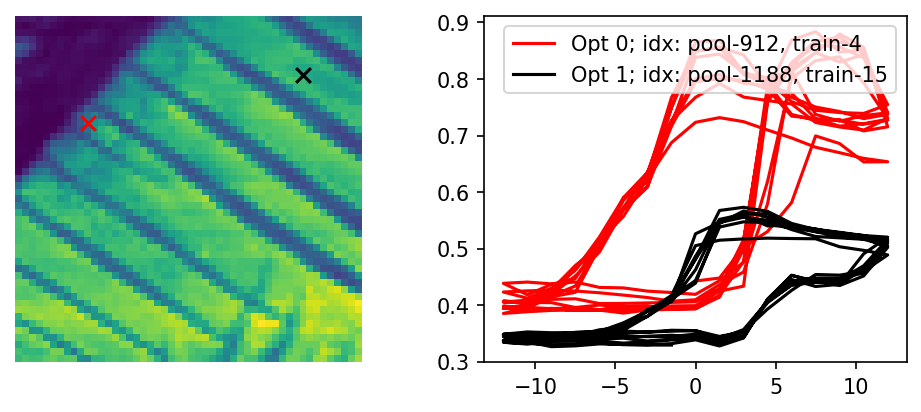

Recorded: train_idx 4 > train_idx 15
Step 5 Summary
Total training points: 16
Total comparisons: 10
Unique acquisition pairs tracked: 10
Current best training index: 5 (pool_idx=1193)


In [15]:
# Parameters
exploration_steps = 5
num_epochs = 1000
top_k = 100
n_pairs_per_point = 1
seed = 0

# Track previous comparisons
previous_comparisons = set()

# Track comparisons from initial data
for comp in train_comp:
    i, j = comp[0].item(), comp[1].item()
    pool_i, pool_j = train_indices[i], train_indices[j]
    previous_comparisons.add((pool_i, pool_j))

# Main loop
for e in range(exploration_steps):
    print(f"Exploration Step {e+1}/{exploration_steps}")

    # train
    mll, pref_model, dkl_model = fit_dkpg(X_train, train_comp, num_epochs=num_epochs)

    # predict on all data
    mean, var = predict_utility(dkl_model, X)

    # Find current best in training set
    train_means, _ = predict_utility(dkl_model, X_train)
    best_train_idx = np.argmax(train_means)

    # visualize prediction
    coord_train = coords[train_indices]
    plot_predictions(coords, y, coord_train, mean, var, step=e+1, total_steps=exploration_steps)

    # acquistion function
    selected_points = acq_eubo(dkl_model=dkl_model, X_pool=X, 
                               previous_comparisons=previous_comparisons,
                               top_k=top_k)

    print(f"Next comparison pair (pool indices): {selected_points}")
    print(f"Point 1: pool_idx={selected_points[0]}, coords={coords[selected_points[0]]}")
    print(f"Point 2: pool_idx={selected_points[1]}, coords={coords[selected_points[1]]}")

    # Track this comparison
    previous_comparisons.add((selected_points[0], selected_points[1]))

    # update train set
    new_indices = []
    for idx in selected_points:
        if idx not in train_indices:
            new_indices.append(idx)

    if len(new_indices) > 0:
        train_indices = np.append(train_indices, new_indices)
        X_train = X[train_indices]
        print(f"Added {len(new_indices)} new points to training set")
        print(f"New pool indices: {new_indices}")
    else:
        print("Both points already in training set")

    # create comparison pairs
    comparison_pairs = sample_comparison_pairs(
        train_indices=train_indices,
        n_pairs_per_point=n_pairs_per_point,
        best_train_idx=best_train_idx if len(new_indices) == 1 else None,
        seed=seed + e)

    # get preference
    new_preference = acquire_preference(
        img_full=img,
        train_indices=train_indices,
        comparison_pairs=comparison_pairs,
        coords=coords,
        spectra=spectra,
        v_step=v_step)

    # Update comparison set
    train_comp = torch.cat([train_comp, new_preference.unsqueeze(0)], dim=0)

    # step summary
    print(f"Step {e+1} Summary")
    print(f"Total training points: {len(X_train)}")
    print(f"Total comparisons: {len(train_comp)}")
    print(f"Unique acquisition pairs tracked: {len(previous_comparisons)}")
    print(f"Current best training index: {best_train_idx} (pool_idx={train_indices[best_train_idx]})")

### Finish

In [16]:
# Finish
_,  _, dkl_model = fit_dkpg(X_train, train_comp, num_epochs=num_epochs)

# ===== PREDICT ON ALL DATA =====
mean, var = predict_utility(dkl_model, X)

Training Deep Kernel PairwiseGP Model
Training on cpu
Input dim: 256, Feature dim: 2
Comparisons: 10
Epoch 100/1000, Loss: 6.1188
Epoch 200/1000, Loss: 5.6021
Epoch 300/1000, Loss: 5.4942
Epoch 400/1000, Loss: 5.4240
Epoch 500/1000, Loss: 5.3735
Epoch 600/1000, Loss: 5.3347
Epoch 700/1000, Loss: 5.3037
Epoch 800/1000, Loss: 5.2780
Epoch 900/1000, Loss: 5.2563
Epoch 1000/1000, Loss: 5.2374


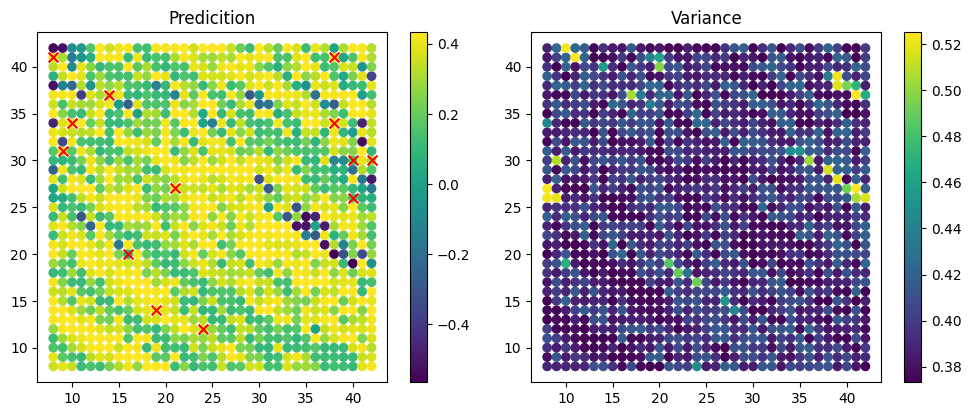

In [35]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

# Ground truth
a = ax1.scatter(coords[:, 1], coords[:, 0], c=mean, cmap="viridis")
plt.colorbar(a, ax=ax1)
ax1.scatter(coord_train[:, 1], coord_train[:, 0], s=50, c='red', marker='x')
ax1.set_title(f'Predicition')
ax1.set_aspect('equal')

# Predicted utility mean
b = ax2.scatter(coords[:, 1], coords[:, 0], c=var, cmap="viridis")
plt.colorbar(b, ax=ax2)
ax2.set_title(f'Variance')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()